# Multimodal analysis of HELA spheroid data

## Load packages

In [1]:
# Load packages
import scanpy as sc
import muon as mu
import matplotlib as mpl
import matplotlib.colors as mcolors
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import sklearn as sk
import phate

mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "Helvetica"

sc.settings.verbosity = 3 

In [2]:
# Plot settings
# Setup the global plotting parameters
sc.logging.print_header()
sc.set_figure_params(dpi=100, color_map = 'viridis', frameon=True, transparent=True,
                    dpi_save=800, facecolor='None', format='pdf', figsize=[5,5])

# Set seed
np.random.seed(0)

# Figure output directory
sc.settings.figdir = 'mm_figures'

# Colour map
colour_dict = {'Control': 'tab:blue', 
               'EGF IGF1': 'tab:green', 
               'GFs MEKi PI3Ki': 'tab:red'}

scanpy==1.9.6 anndata==0.10.4 umap==0.5.5 numpy==1.26.3 scipy==1.12.0 pandas==2.2.0 scikit-learn==1.4.0 statsmodels==0.14.1 igraph==0.10.4 pynndescent==0.5.11


# Load data after preprocessing

In [3]:
# Load data
# File path
fp_mdata = '2023_03_30_mdata_01.h5mu'

# Load the Muon SIGNAL-seq object
mdata = mu.read(fp_mdata)

mdata

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


MuData object with n_obs × n_vars = 1143 × 29260
  var:	'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
  2 modalities
    rna:	1143 x 29237
      obs:	'sub_lib_id', 'sum', 'detected', 'total', 'sample_id', 'well_indexes', 'barcode_seq', 'mapped_reads', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_lnc', 'pct_counts_lnc', 'log10_total_counts', 'umi_rds_ratio', 'outlier_total', 'outlier_ngenes', 'lowq_counts', 'lowq_mt', 'outlier_rds', 'n_genes', 'S_score', 'G2M_score', 'phase', 'Amit_Nat_Gen_2007', 'pP120-Catenin_[T310]', 'pRB_[S807/811]_v1', 'cCaspase_3_[D175]_v2', 'pPDPK1_[S241]', 'pMKK4/SEK1_[S257]', 'pBTK_[Y551]_1_v2', 'p4E-BP1_[T37/46]_v2', 'pAKT_[T308]', 'pNF-κB_p65_[S529]', 'pP38_MAPK_[T180/Y182]_v2', 'pS6_[S240/S244]_2', 'CK18', 'Cyclin_B1_2', 'pNDRG1_[T346]', 'me2_Histone_H3_[K4]'
      var:	'gene_ids', 'lnc', 'lncipediaGeneID', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
      uns:	'X_name', 'hvg', 'library_info', 'library_stats', 'log1p', 'pca', 'phase_colors', 'sample_id_colors', 'seq_run_info'
      obsm:	'X_pca', 'X_phate', 'X_ptm_phate'
      varm:	'PCs'
      layers:	'counts', 'reads'
    protein:	1143 x 23
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'barcode_1', 'barcode_2', 'barcode_3', 'barcode_2_3', 'index_1', 'sample_id', 'index_2', 'index_3', 'outlier_nantigens', 'outlier_adt_counts'
      var:	'feature_name', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
      uns:	'sample_id_colors'
      obsm:	'X_ptm_phate', 'ptm_pca', 'rna_phate'
      layers:	'counts'

In [4]:
prot_adata_clr = mdata.mod['protein']
adata_mrna_filtered = mdata.mod['rna']
prot_adata_clr

AnnData object with n_obs × n_vars = 1143 × 23
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'barcode_1', 'barcode_2', 'barcode_3', 'barcode_2_3', 'index_1', 'sample_id', 'index_2', 'index_3', 'outlier_nantigens', 'outlier_adt_counts'
    var: 'feature_name', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'sample_id_colors'
    obsm: 'X_ptm_phate', 'ptm_pca', 'rna_phate'
    layers: 'counts'

In [5]:
# Selecting markers for PHATE 
ptm_markers = ['pP120-Catenin_[T310]',
       'pRB_[S807/811]_v1', 'cCaspase_3_[D175]_v2',
       'pMKK4/SEK1_[S257]', 'pBTK_[Y551]_1_v2', 'p4E-BP1_[T37/46]_v2',
       'pNF-κB_p65_[S529]', 'pP38_MAPK_[T180/Y182]_v2',
        'pS6_[S240/S244]_2', 'CK18', 'Cyclin_B1_2', 
        'pNDRG1_[T346]', 'me2_Histone_H3_[K4]']

# All markers
protein_markers = prot_adata_clr.var_names

# Export all the CLR(ADT) data
protein_data_clr_df = sc.get.obs_df(
    prot_adata_clr,
    keys=['sample_id' , 'total_counts', *protein_markers]
)

protein_data_clr_df.to_csv('ptm_data_clr.csv')


In [6]:
# Subset df to only PTM markers
ptm_marker_df = protein_data_clr_df[ptm_markers]

In [7]:
# Generate Phate plots
# Run phate on the PTM data
phate_op = phate.PHATE(random_state=0)

Y = phate_op.fit_transform(ptm_marker_df)

Calculating PHATE...
  Running PHATE on 1143 observations and 13 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.03 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.05 seconds.
  Calculating optimal t...
    Automatically selected t = 29
  Calculated optimal t in 0.71 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.17 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 1.43 seconds.
Calculated PHATE in 2.38 seconds.


In [8]:
# Reassign object with ADT phate
prot_adata_clr.obsm['X_ptm_phate'] = Y

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be i

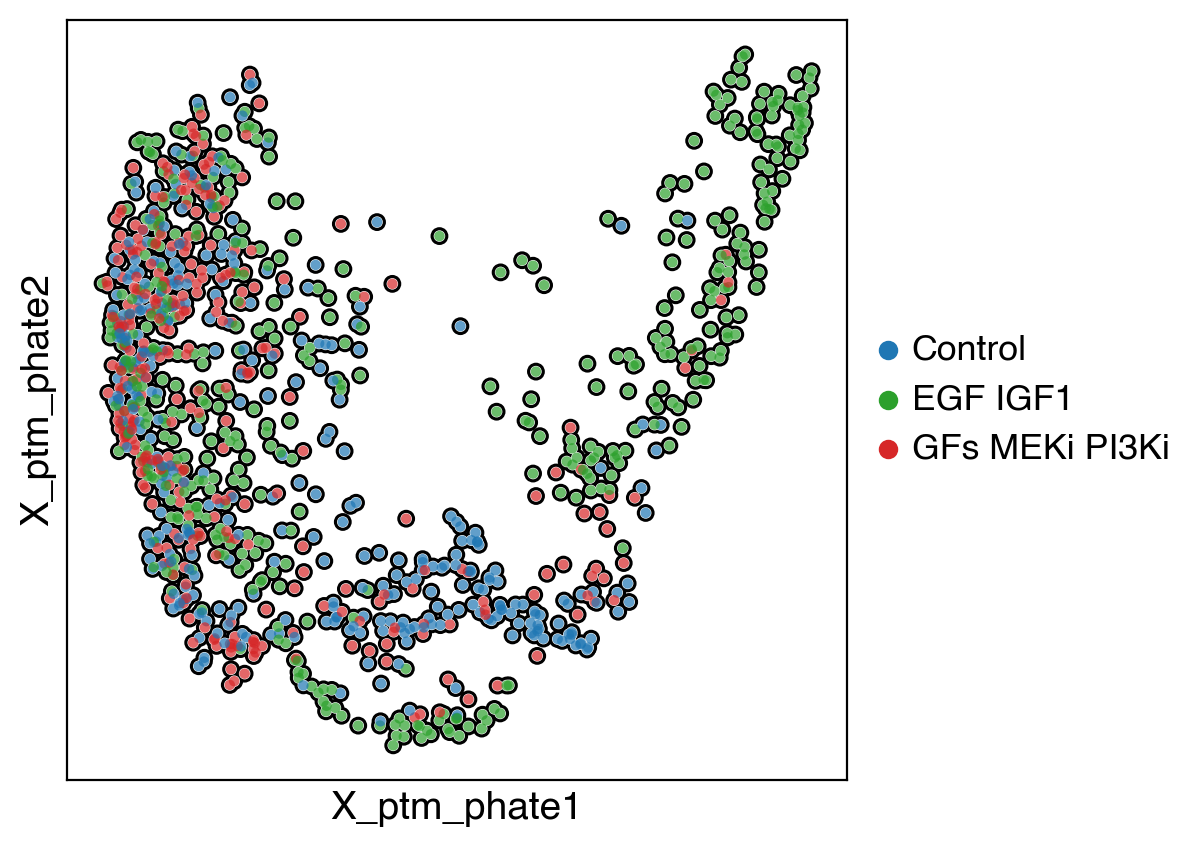

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provide

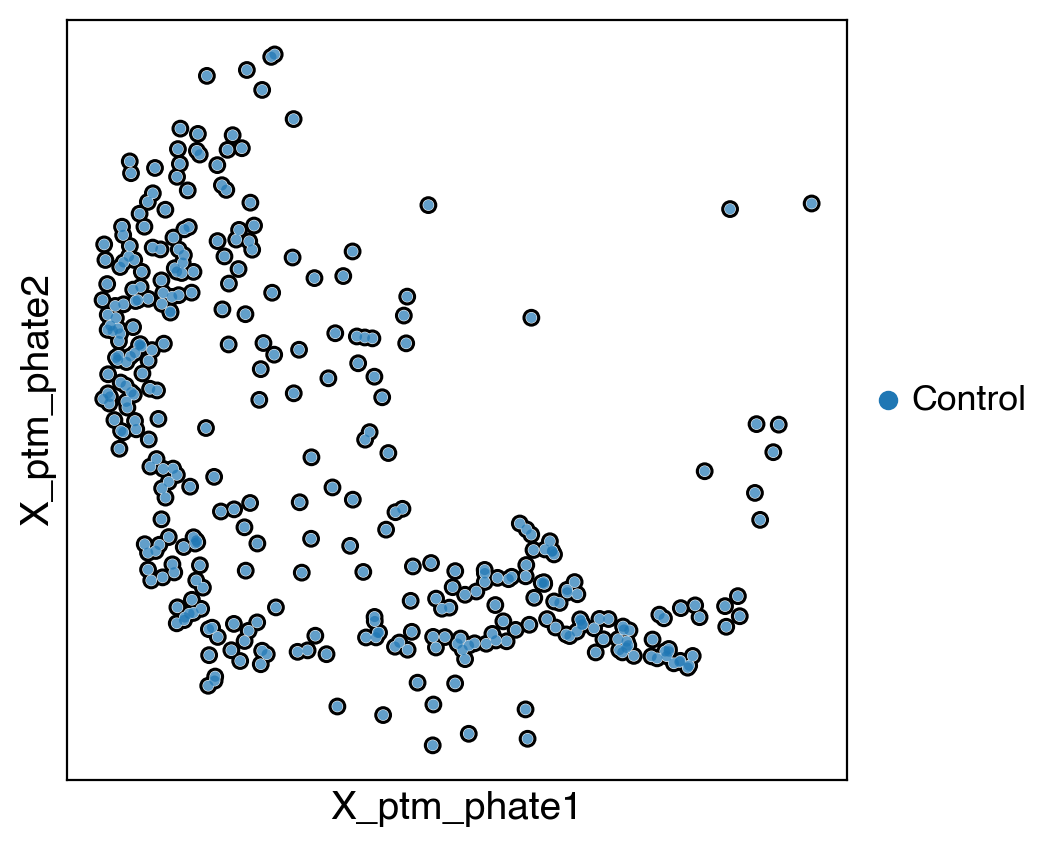

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provide

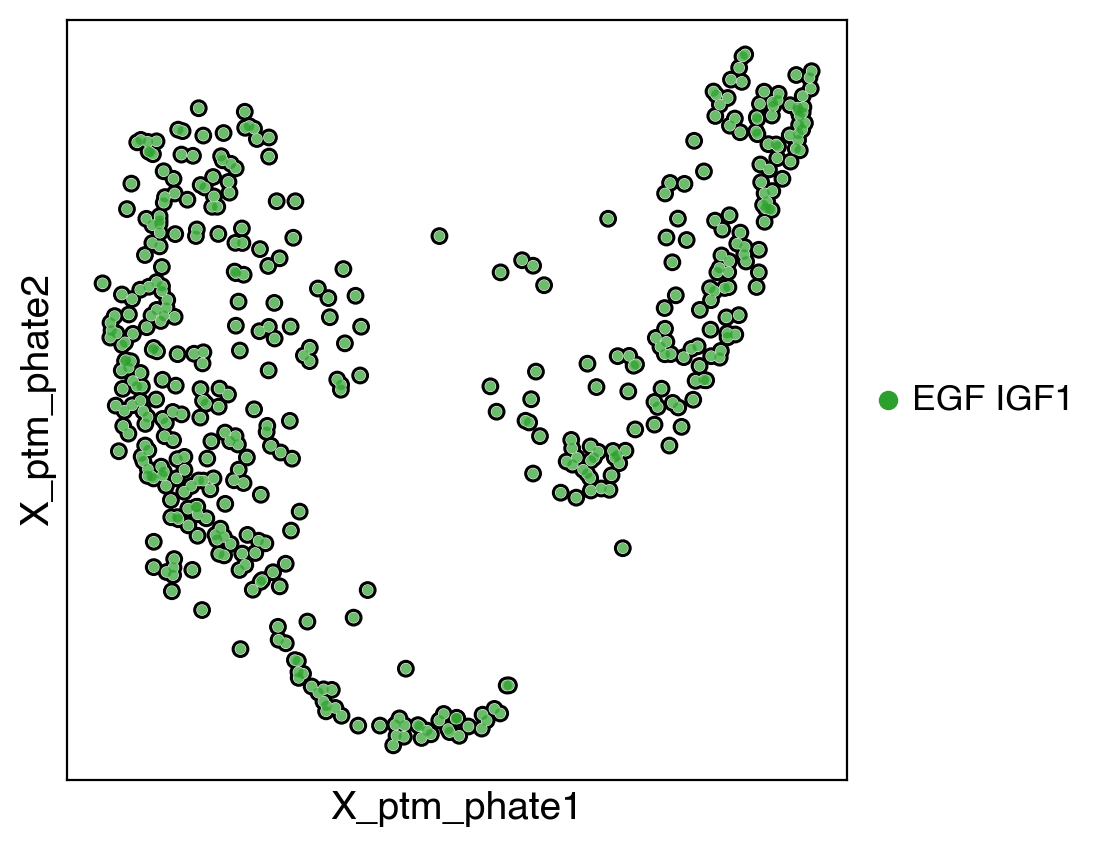

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provide

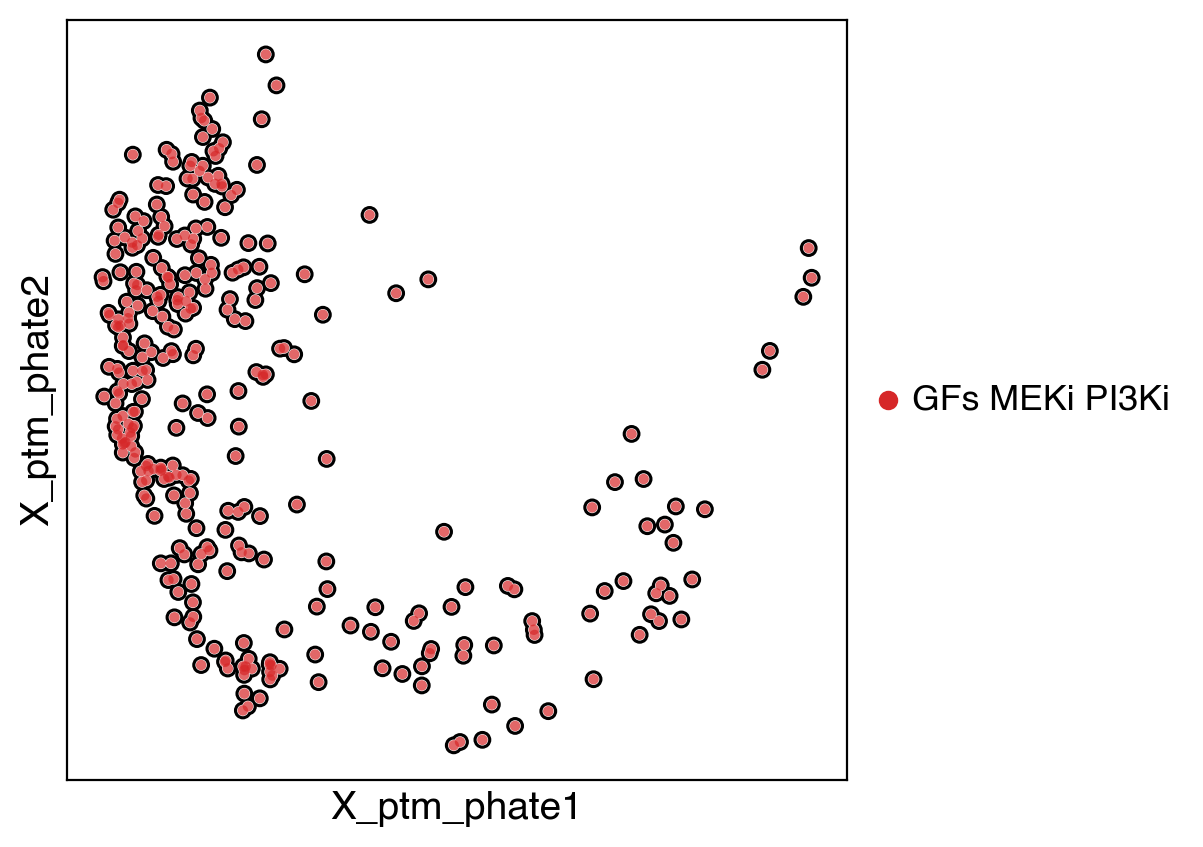

In [9]:
# View the ADT phates with sample_id colour
sc.pl.embedding(prot_adata_clr, basis='X_ptm_phate', color='sample_id', palette=colour_dict, 
frameon=True, add_outline=True, size = 57, title='', save="_adt_phate_all_conds")

# Subset only one sample_id
prot_adata_control = prot_adata_clr[prot_adata_clr.obs['sample_id'].isin(['Control'])]
sc.pl.embedding(prot_adata_control, basis='X_ptm_phate', color='sample_id', palette=colour_dict, 
frameon=True, add_outline=True, size = 57, title='', save="_adt_phate_control")

prot_adata_GF = prot_adata_clr[prot_adata_clr.obs['sample_id'].isin(['EGF IGF1'])]
sc.pl.embedding(prot_adata_GF, basis='X_ptm_phate', color='sample_id', palette=colour_dict, 
frameon=True, add_outline=True, size = 57, title='', save="_adt_phate_GFs")

prot_adata_GFI = prot_adata_clr[prot_adata_clr.obs['sample_id'].isin(['GFs MEKi PI3Ki'])]
sc.pl.embedding(prot_adata_GFI, basis='X_ptm_phate', color='sample_id', palette=colour_dict, 
frameon=True, add_outline=True, size = 57, title='', save="_adt_phate_ihibs")


In [10]:
# Swap the embeddings to do cross modality measurments
# Reassign object with ADT phate
adata_mrna_filtered.obsm['X_ptm_phate'] = Y

In [11]:
# add the PTM measurements in obs of RNA object
adata_mrna_filtered.obs[ptm_markers] = ptm_marker_df

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


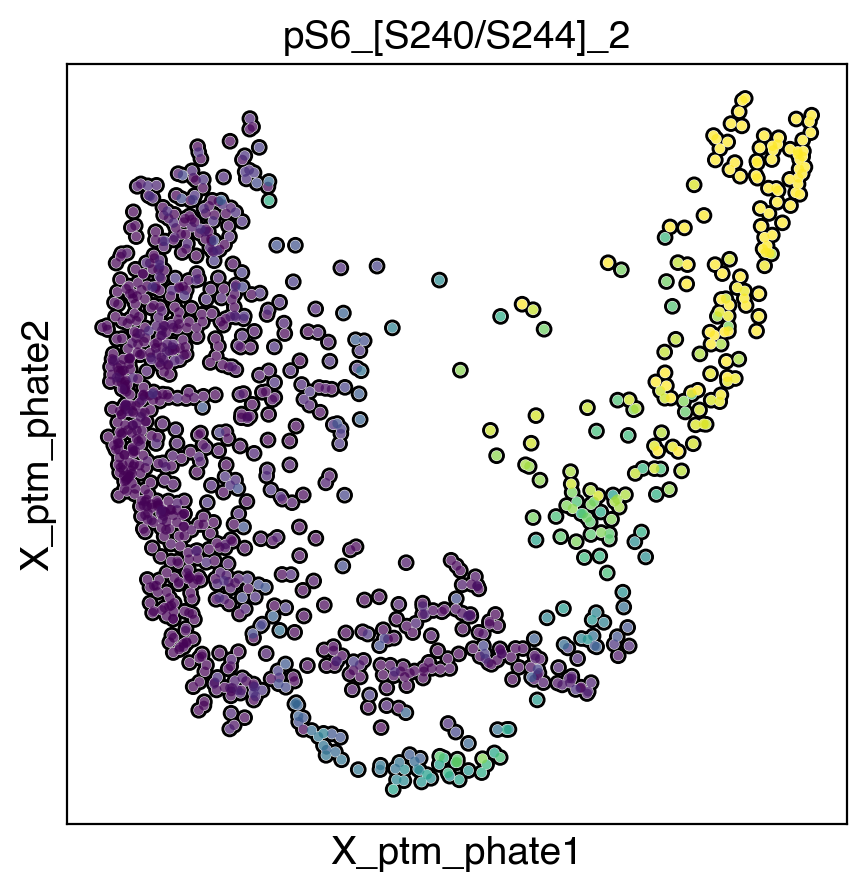

In [12]:
# Plot GEP activities
sc.pl.embedding(prot_adata_clr, basis='X_ptm_phate', color='pS6_[S240/S244]_2', add_outline=True,
           vmin=0.25, vmax=5, ncols = 4, frameon=True, size=50, colorbar_loc=None,
           save = 'adt_phate_pS6')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


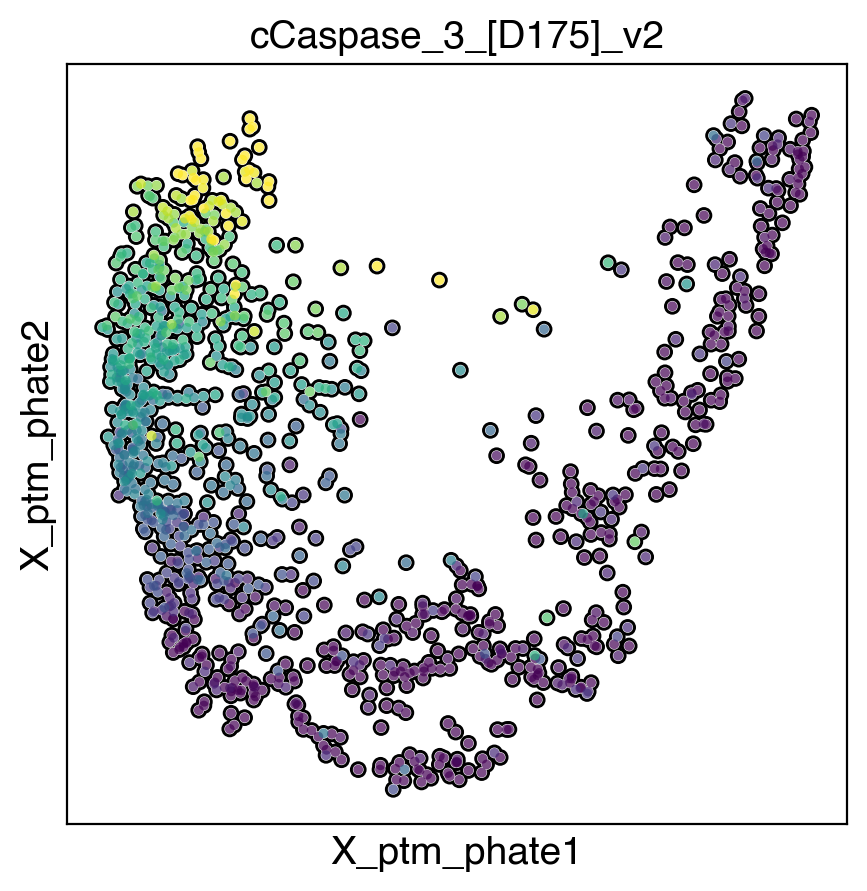

In [13]:
# Plot GEP activities
sc.pl.embedding(prot_adata_clr, basis='X_ptm_phate', color='cCaspase_3_[D175]_v2', add_outline=True,
           vmin=0.25, vmax=2.25, ncols = 4, frameon=True, size=50, colorbar_loc=None, 
           save = 'adt_phate_cCasp3')


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


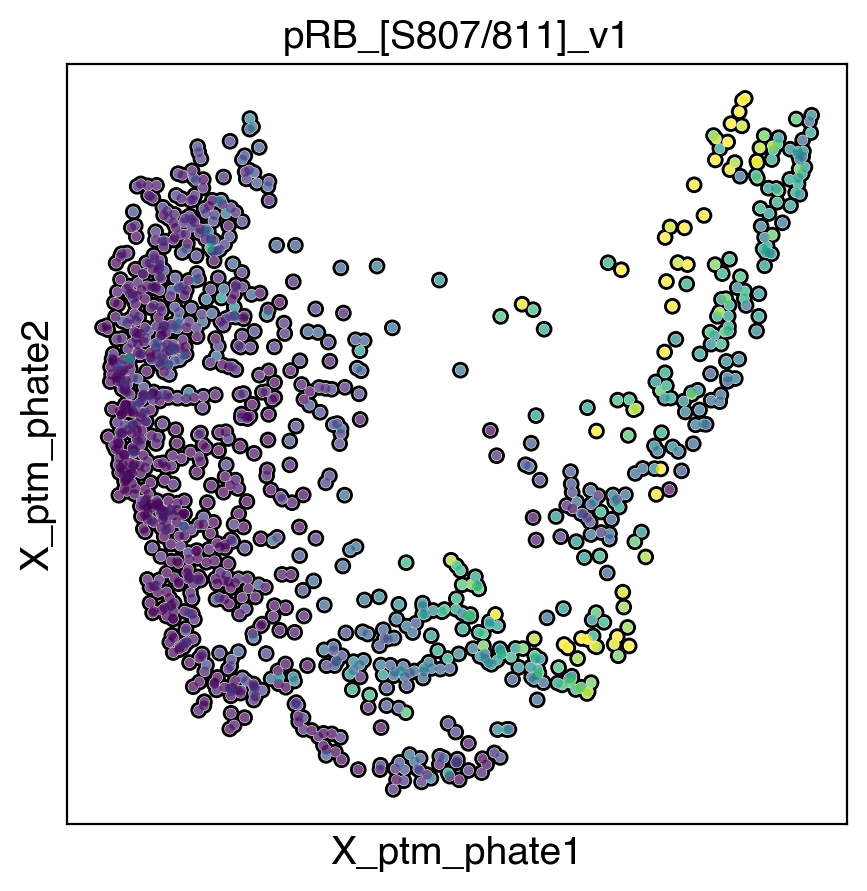

In [14]:
# Plot GEP activities
sc.pl.embedding(prot_adata_clr, basis='X_ptm_phate', color='pRB_[S807/811]_v1', add_outline=True,
           vmin=0.25, vmax=3, ncols = 4, frameon=True, size=50, colorbar_loc=None,
           save = 'adt_phate_pRb')

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


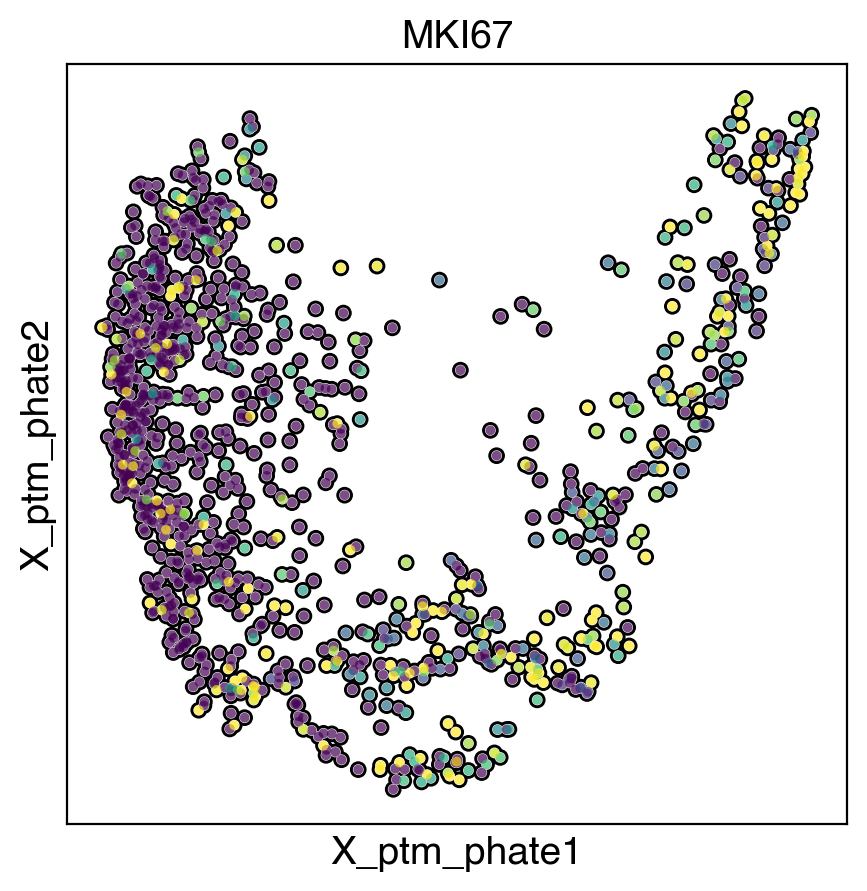

In [15]:
# Plot GEP activities
sc.pl.embedding(adata_mrna_filtered, basis='X_ptm_phate', color='MKI67', add_outline=True,
           frameon=True, size=50, vmin=0, vmax=3, colorbar_loc=None,
           save = 'adt_phate_mki67')

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


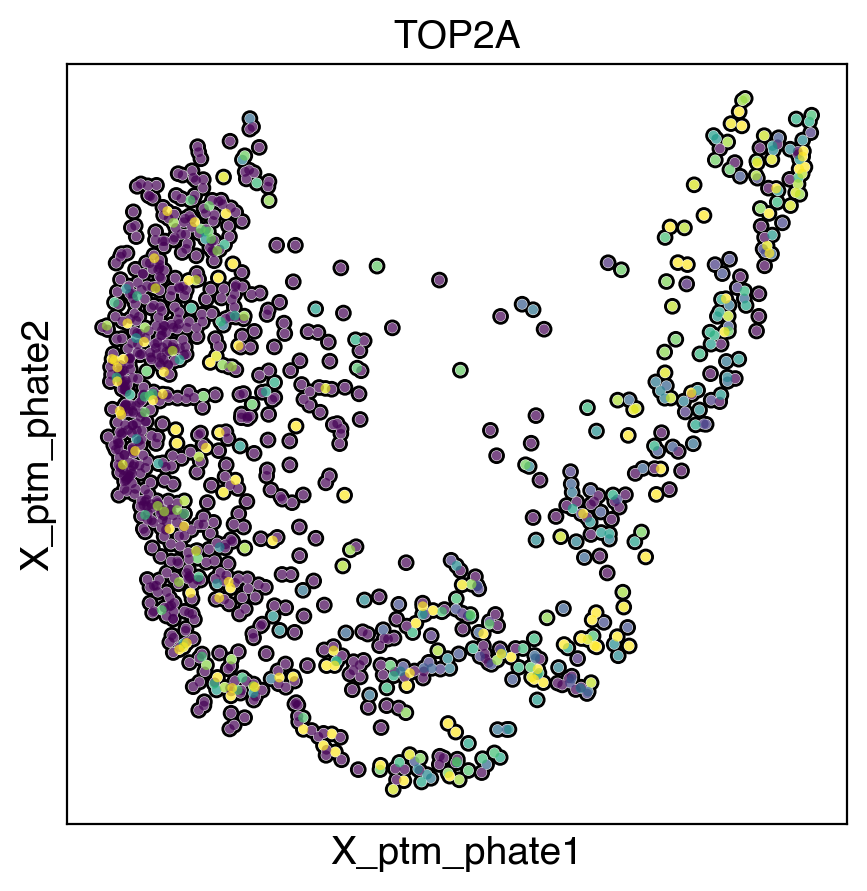

In [16]:
# Plot GEP activities
sc.pl.embedding(adata_mrna_filtered, basis='X_ptm_phate', color='TOP2A', add_outline=True,
           frameon=True, size=50, vmin=0, vmax=3, colorbar_loc=None,
           save = 'adt_phate_top2a')

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


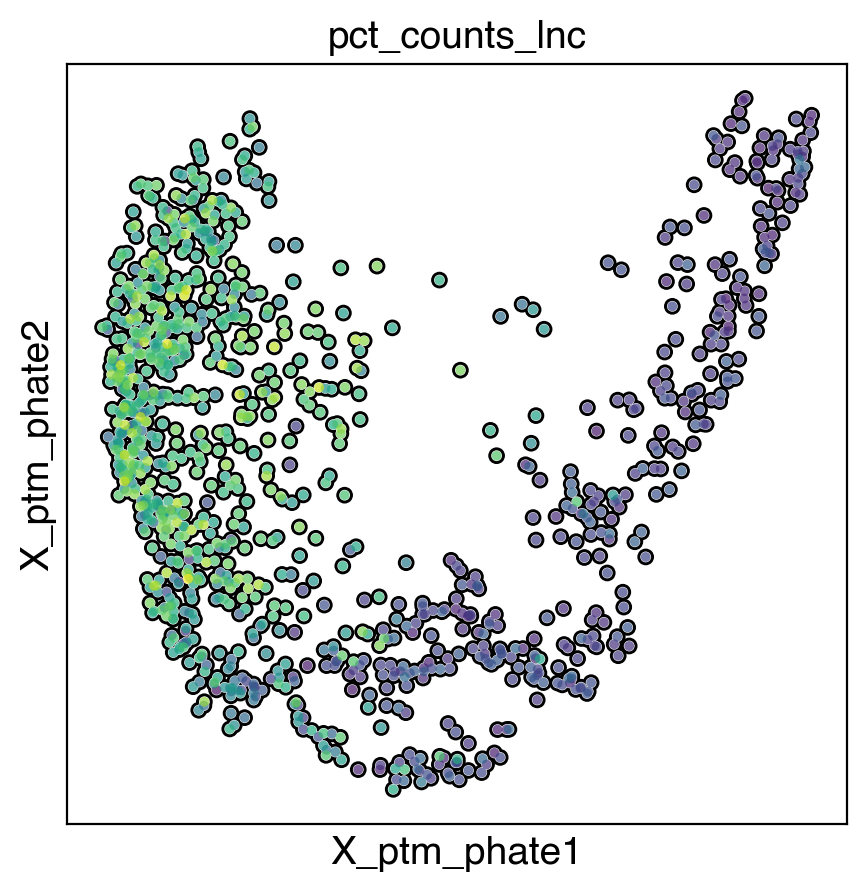

In [17]:
# Map onto object
sc.pl.embedding(adata_mrna_filtered, basis='X_ptm_phate', color='pct_counts_lnc', add_outline=True,
           vmin=0, vmax=70, ncols = 4, frameon=True, size=50, colorbar_loc=None,
           save = 'adt_phate_rna-lnc_annotation')

In [18]:
# Generate Rb and pS6 correlation
# Extract RNAdata
marker_genes = adata_mrna_filtered.var_names
ln_rna_data  = adata_mrna_filtered.raw.to_adata()
ln_rna_data.obs = adata_mrna_filtered.obs

# Get function
ln_mrna_data = sc.get.obs_df(
    ln_rna_data,
    keys=[*marker_genes]
)

In [19]:
# Extract the marker data from the adata object
mrna_data_obs = sc.get.obs_df(
    ln_rna_data,
    keys=['well_indexes', 'Amit_Nat_Gen_2007', 'sample_id', 'phase','n_genes_by_counts' , 'total_counts', *marker_genes]
)

mrna_data_obs.to_csv('ex0003_mrna_obsm_data.csv')

In [20]:
# Calculate correlation for each column
correlation_results = ln_mrna_data.apply(lambda col: col.corr(pd.Series(adata_mrna_filtered.obs['pS6_[S240/S244]_2'])))

# Sort the correlation results in descending order
correlation_results_sorted = correlation_results.sort_values(ascending=False)

In [21]:
# Extract gene_names
ps6_df = pd.DataFrame(correlation_results_sorted).reset_index()
ps6_df.to_csv('ps6_corr.csv')

In [22]:
# Load amit genes
amit_gene_df = pd.read_csv('../02_preprocessing_multimodal/data/amit_early_egf_genes.csv')

# List of strings to match
amit_genes = amit_gene_df['gene_symbol_20_40min'].to_list()

# extract the amit gene list
ps6_amit_df = ps6_df[ps6_df['index'].isin(amit_genes)]

In [23]:
# generate rank from index
rank_corr_df = ps6_df.reset_index()
rank_corr_df = rank_corr_df.rename(columns={"level_0": "rank", "index": "gene", 0:"corr"})

rank_genes = ps6_amit_df['index'][:10]

# Creating a new column 'genes' with True/False values
rank_corr_df['amit_genes'] = rank_corr_df['gene'].apply(lambda x: any(gene == x for gene in rank_genes))

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


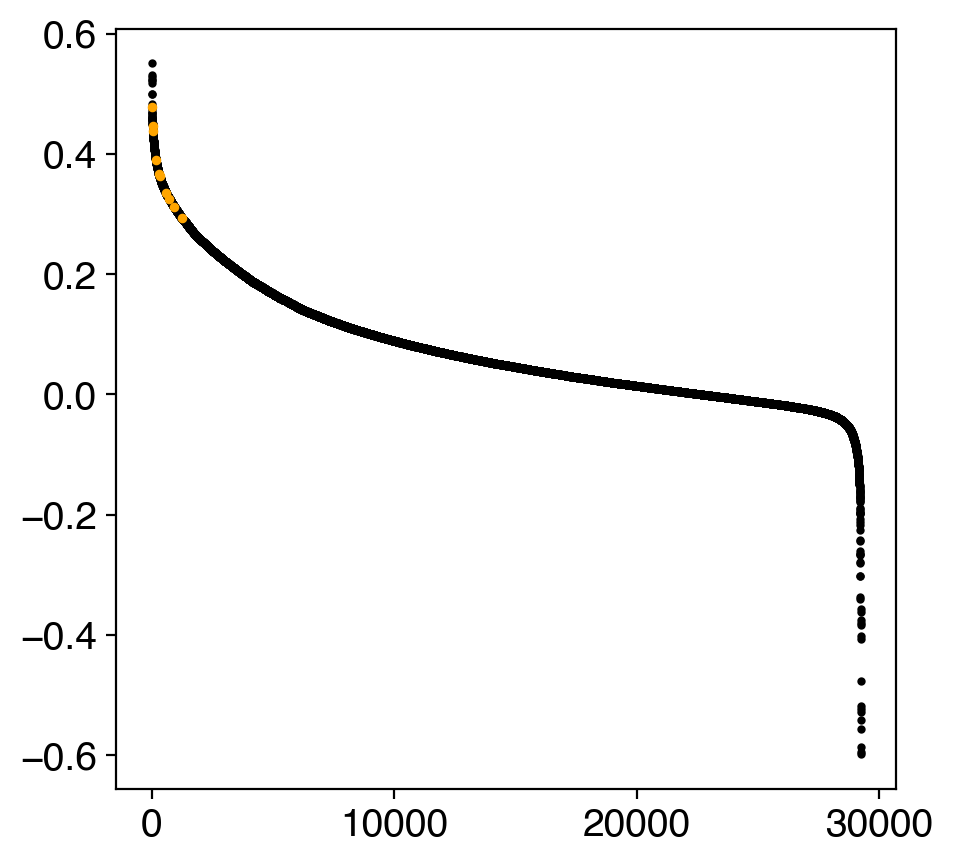

In [24]:
fig, axs = plt.subplots(1, 1)

plot_mask = rank_corr_df['amit_genes'] == True

axs.scatter(rank_corr_df.loc[~plot_mask, 'rank'], rank_corr_df.loc[~plot_mask, 'corr'], c='black', label='gene', s=4)
axs.scatter(rank_corr_df.loc[plot_mask, 'rank'], rank_corr_df.loc[plot_mask, 'corr'], c='orange', label='EGF Respnse gene', s=6)
axs.legend([], [], frameon=False)

# Turns off grid on the left Axis.
axs.grid(False)

plt.savefig("mm_figures/egf_response_barcode_rankplot.pdf")

In [25]:
rank_corr_df['amit_genes'] == True

0        False
1        False
2        False
3        False
4        False
         ...  
29232    False
29233    False
29234    False
29235    False
29236    False
Name: amit_genes, Length: 29237, dtype: bool

In [26]:
rank_corr_df.loc[plot_mask]

rank    gene      corr  amit_genes
10      10    EGR1  0.477294        True
35      35  TIPARP  0.446717        True
46      46     FOS  0.437537        True
173    173   NR4A3  0.389150        True
286    286    NFIB  0.366781        True
321    321   MBNL1  0.362470        True
589    589    KLF6  0.334777        True
718    718   KLF10  0.325571        True
933    933    JUNB  0.311520        True
1243  1243   PIAS1  0.293069        True

/var/folders/rk/05jx38f57w75573dgxbjlrm40000gn/T/ipykernel_36013/2029227459.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = mpl.cm.get_cmap('PiYG')
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


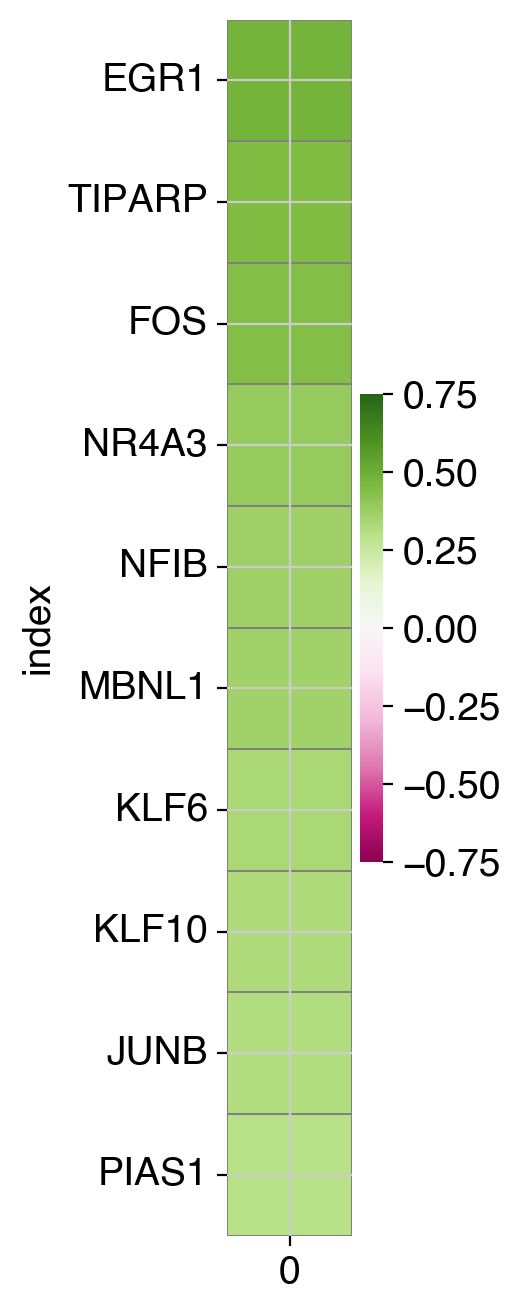

In [27]:
# Plot ordered correlation heatmap
hm_df = ps6_amit_df.set_index("index").head(n=10)

fig, ax = plt.subplots(figsize=(1, 8))
colormap = mpl.cm.get_cmap('PiYG')
offset = mcolors.TwoSlopeNorm(vcenter=-0, vmin = -0.75, vmax = 0.75)
sns.heatmap(hm_df, cmap=colormap,norm=offset, linewidths = 0.05, linecolor='grey')
plt.savefig('cell_state.pdf', dpi=600, transparent=True, bbox_inches='tight')
plt.show()

In [28]:
sc.pp.scale(adata_mrna_filtered, max_value=10)

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


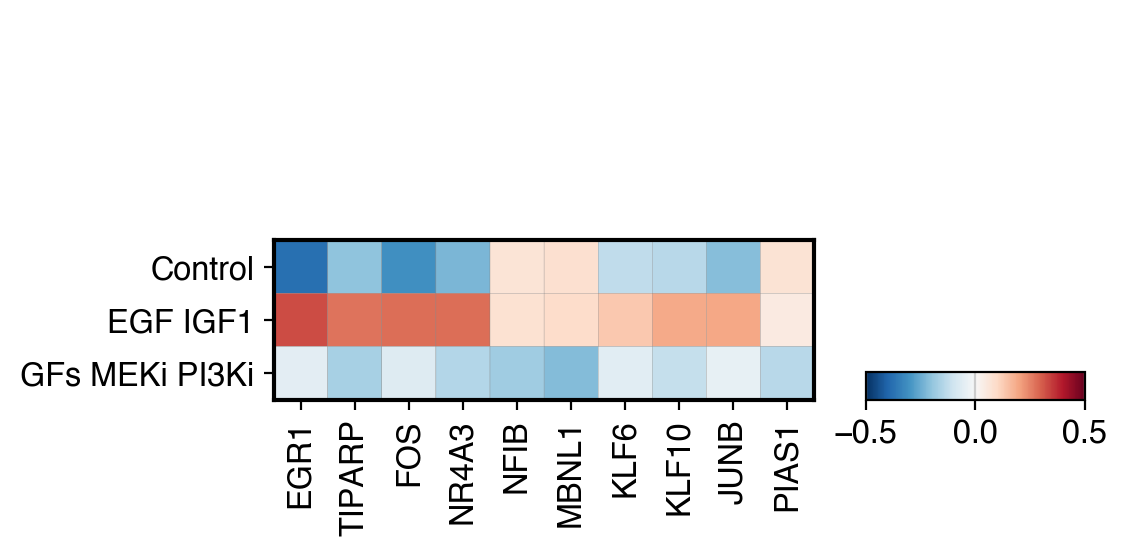

In [29]:
amit_genes_hm = ps6_amit_df['index'].to_list()[:10]
sc.pl.matrixplot(adata_mrna_filtered, amit_genes_hm, groupby='sample_id', dendrogram=False, use_raw=False,
                 categories_order=['Control', 'EGF IGF1', 'GFs MEKi PI3Ki'],
                 colorbar_title='', vmin=-0.5, vmax=0.5, cmap= 'RdBu_r', save='col_zscaled_amit_EGF_response.pdf')